In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

import matplotlib.pyplot as plt

In [3]:
from app.utils import ImageWrapper
from app.models import Classifier
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
## Utility function:
def variance_plot(explained_var_ratio, n_components, pct = True):
    """Helper function to plot the captured variance"""
    
    # Define X axis intervals:
    x=np.arange(1, n_components + 1)
    # Cumulative variance:
    if pct:
        y1 = explained_var_ratio * 100
    else:
        y1 = explained_var_ratio
    y2 = np.cumsum(y1)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.bar(x, y1, color = 'g')
    ax2.plot(x, y2, color = 'b')
    
    ax1.set_xlabel('Principal Component Number')
    ax1.set_xticks(x)
    
    if pct:
        ax1.set_ylabel('Explained Variance %', color='g')
        ax2.set_ylabel('Cumlative Explained Variance %', color='b')
    else:
        ax1.set_ylabel('Explained Variance', color='g')
        ax2.set_ylabel('Cumlative Explained Variance', color='b')
        
def plot_gallery(images, h=0, w=0, n_row=4, n_col=5):
    """Helper function to plot a gallery of portraits
       Adapted from https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if h !=-0:
            plt.imshow(images[i].reshape((h, w)), cmap='Greys_r')
        else:
            plt.imshow(images[i], cmap='Greys_r')
        plt.title(f'Eigenface_{i+1}', size=12)
        plt.xticks(())
        plt.yticks(())

def get_n_samples(n_samples):
    
    closed = (DefectViewer() << (ImageLoader(defect_class='Corrosion') << n_samples))
    closed.category = 'Corrosion'
    clean = (DefectViewer() << (ImageLoader(defect_class='None') << n_samples))
    clean.category = 'Clean'
    all_others = (DefectViewer() << (ImageLoader(defect_class=['Resistive', 'Isolated', 'Closed', 'FrontGridInterruption', 'BrightSpot', 'NearSolderPad']) << n_samples))
    all_others.category = 'all_others'
    
    closed_ = closed.copy()
    closed = closed - all_others
    all_others = all_others - closed_
    clean = clean - closed_
    return closed, clean, all_others

In [5]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

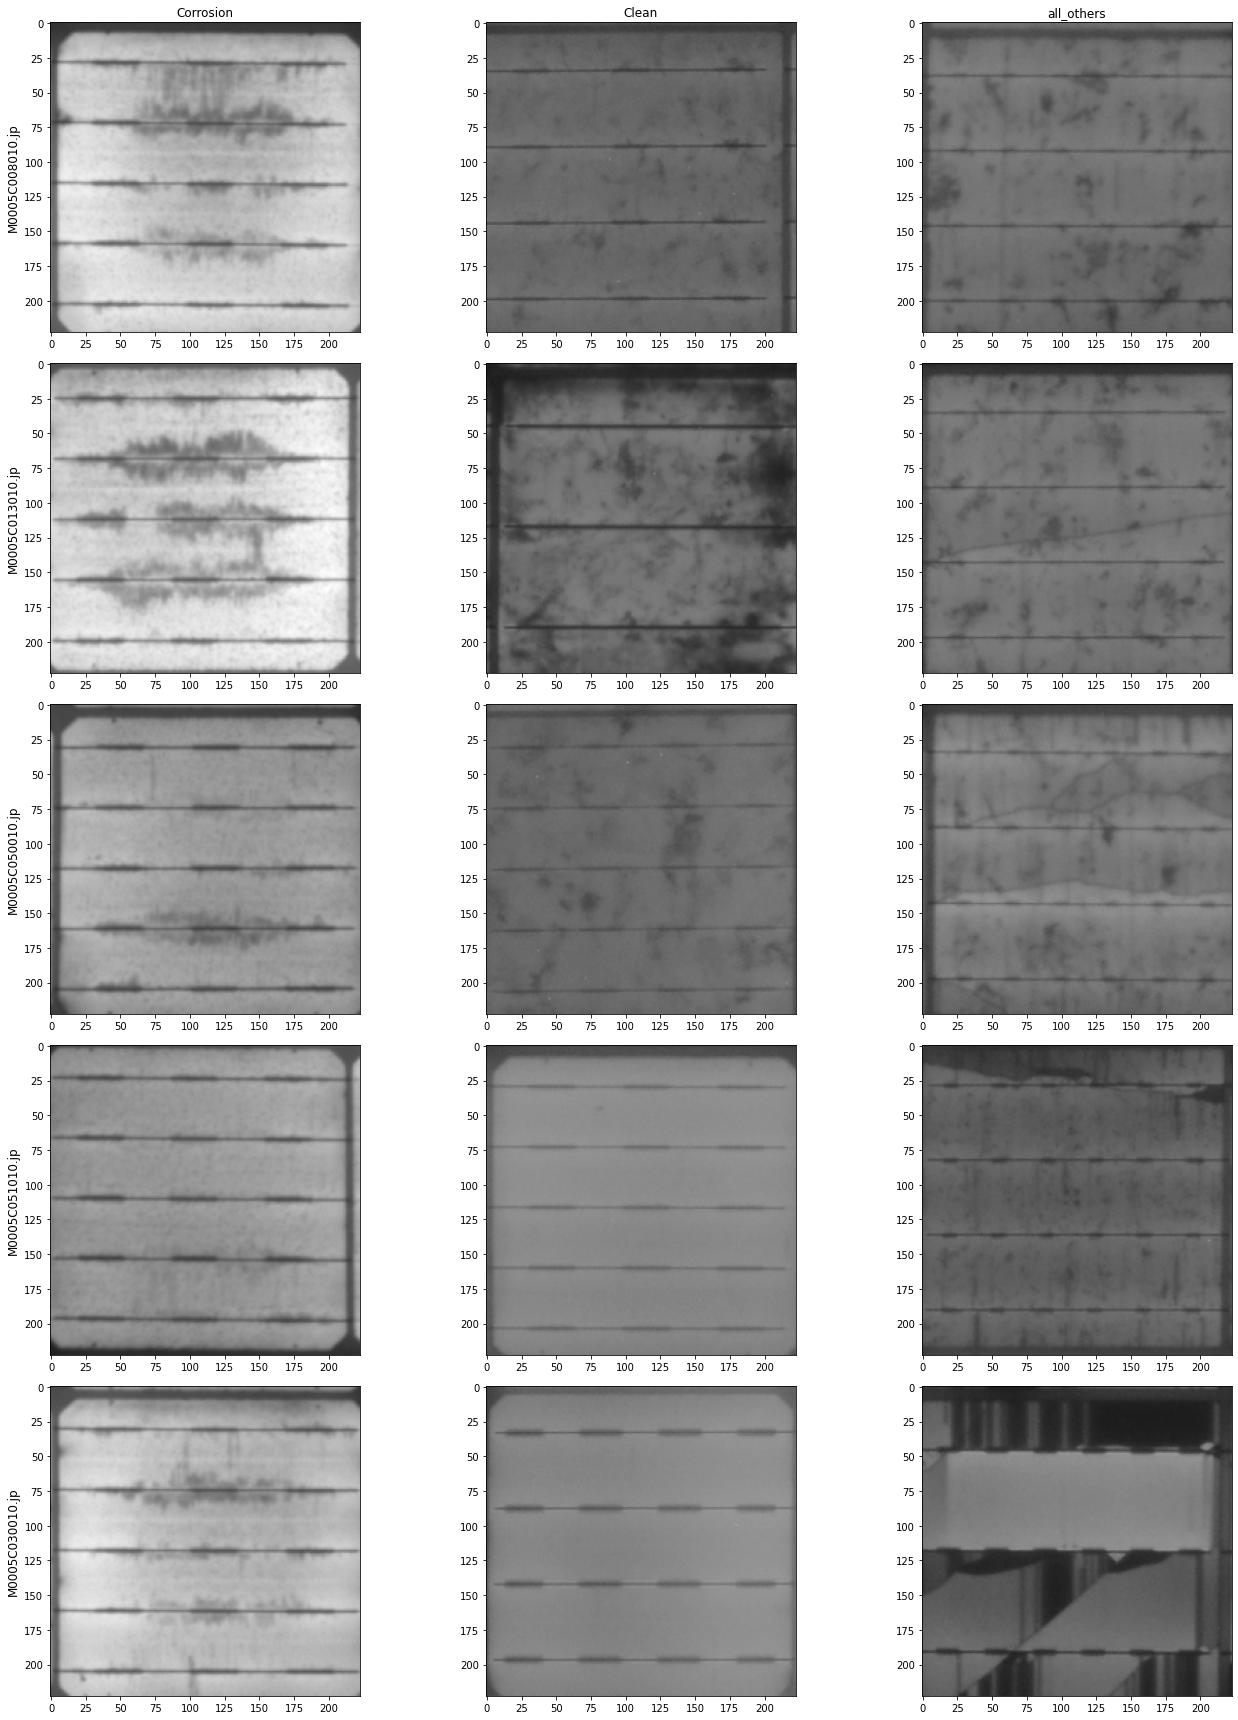

In [6]:
# Load 100 examples and name the category for it. Category is like a title for images
n_samples = 500
defect, clean, all_others =  get_n_samples(n_samples)
_ = Show(num_images=5, seed=seed) << (defect, clean, all_others)

# Basemodel 

In [7]:
import tabulate
# Base model on raw data - single defect vs. clean
title = 'Base model single defect vs. clean'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': 160}
cla = Classifier(defect, clean, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print("Score for:", title, " ", score, "\n")

# Misclassified
conf, out = cla.misclassified()
print(title)
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


title = '\nBase model all images with defect vs. rest of images'
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': 160}
cla = Classifier(defect, all_others, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print("Score for:", title, " ", score, "\n")

# Misclassified
print(title)
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


Score for: Base model single defect vs. clean   1.0 

Base model single defect vs. clean
          Pred 0    Pred 1
------  --------  --------
True 0       103         0
True 1         0         4
Score for: 
Base model all images with defect vs. rest of images   0.9951456310679612 


Base model all images with defect vs. rest of images
          Pred 0    Pred 1
------  --------  --------
True 0       102         1
True 1         0         4


In [8]:
from app.transforms import MaskedFFT

ones_mask = np.ones(defect.images[0].shape)
_, defect_mask =MaskedFFT(mask=ones_mask) << defect
_, clean_mask =MaskedFFT(mask=ones_mask) << clean
_, all_others_mask =MaskedFFT(mask=ones_mask) << all_others

# Base model on raw data - single defect vs. clean
title = 'Base model single defect vs. clean'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': 160}
cla = Classifier(defect_mask, clean_mask, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print("Score for:", title, " ", score, "\n")

# Misclassified
conf, out = cla.misclassified()
print(title)
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


title = '\nBase model all images with defect vs. rest of images'
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': 160}
cla = Classifier(defect_mask, all_others_mask, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print("Score for:", title, " ", score, "\n")

# Misclassified
print(title)
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


Score for: Base model single defect vs. clean   1.0 

Base model single defect vs. clean
          Pred 0    Pred 1
------  --------  --------
True 0       103         0
True 1         0         4
Score for: 
Base model all images with defect vs. rest of images   0.9902912621359223 


Base model all images with defect vs. rest of images
          Pred 0    Pred 1
------  --------  --------
True 0       101         2
True 1         0         4


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## What does the mean Clean and Corrosion Image look like?

In [9]:
# Calculate the average of all images within each category. 
average_clean = np.mean(clean.images, axis=0)
average_corrosion = np.mean(defect.images, axis=0)

Average Clean Cell


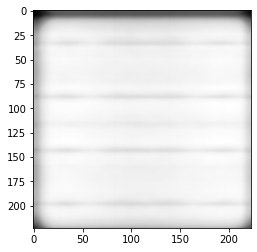

In [10]:
print('Average Clean Cell')
plt.imshow(average_clean, cmap='Greys_r')

Average Corroded Image


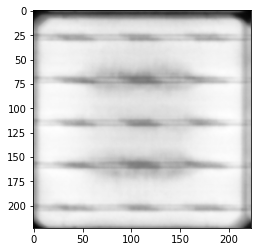

In [11]:
print('Average Corroded Image')
plt.imshow(average_corrosion, cmap='Greys_r')

## PCA on all images
### Analysis of principal components and variance 

20 principal components explain 94.19 % of the total variance


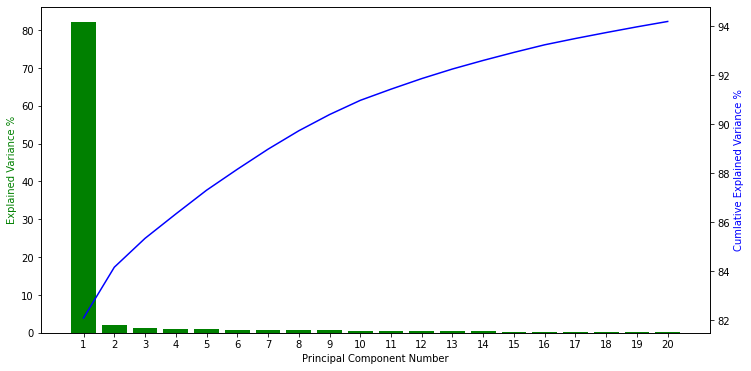

In [13]:
# Instantiate class
n =20
PCA_class_all_others = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_all_others << clean

# Total explained Variance
exp_var = PCA_class_all_others.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

20 principal components explain 99.05 % of the total variance


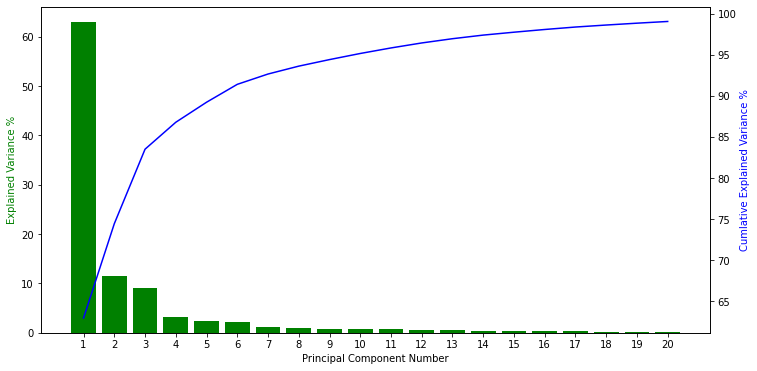

In [14]:
# Instantiate class
n = 20
PCA_class_defect = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_defect << defect

# Total explained Variance
exp_var = PCA_class_defect.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

### Let's view the Eigenfaces of each

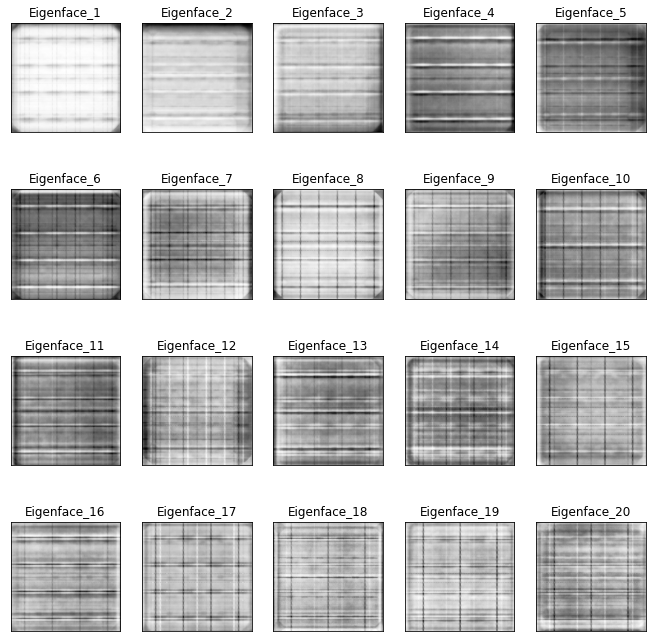

In [15]:
## Clean images
plot_gallery(PCA_class_all_others.eigenfaces[0])

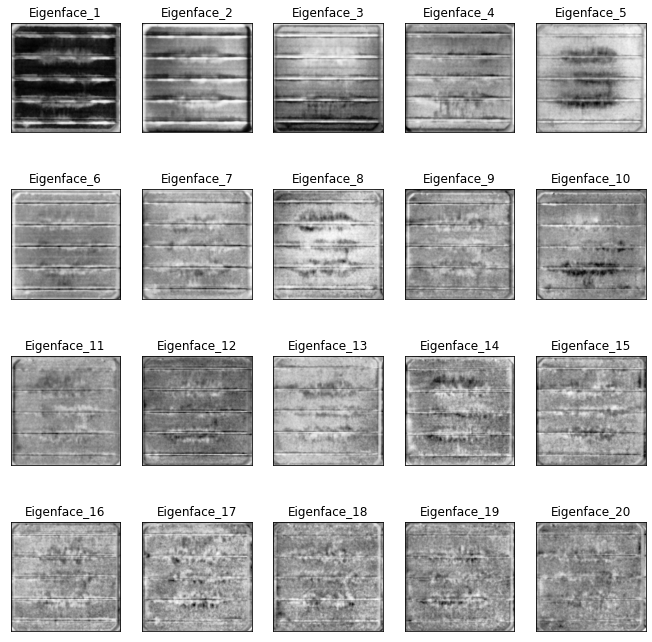

In [72]:
## Defected images
plot_gallery(PCA_class_defect.eigenfaces[0])

In [12]:
def get_cosine_similarity(template, img_array):
    """ Returns the cosine similarity of the top N eigenfaces.""" 
    
    #Get dims
    N, H, W = img_array.images.shape
    #Reshape images
    reshaped = img_array.images.reshape(N, H * W)
    # Reshape template
    stacked_face = template.reshape(len(template), H*W)
    # Calculate similarity
    sim = cosine_similarity(stacked_face, reshaped)
    
    return sim

In [126]:
eigenfaces = PCA_class_defect.eigenfaces[0]
sim_scores_clean = get_cosine_similarity(eigenfaces, clean)
sim_scores_defect = get_cosine_similarity(eigenfaces, defect)
sim_scores_all_others = get_cosine_similarity(eigenfaces, all_others)

print(np.sum(sim_scores_clean))
print(np.sum(sim_scores_defect))

-461.7884644387256
-84.55792471306277


In [75]:
# base- single defect vs. clean
title = 'Base Model single defect vs. clean'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defect, all_others, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print("Score for:", title, " ", score, "\n")

Score for: Base Model single defect vs. clean   0.9666666666666667 



C:\Users\andim\PycharmProjects\W281\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [124]:
data = np.concatenate((sim_scores_defect,sim_scores_clean), axis=1)
data = data.T
defect_label = np.ones(sim_scores_defect[0].shape)
clean_label = np.zeros(sim_scores_clean[0].shape)
labels = np.concatenate((defect_label,clean_label),axis=0)

title = 'Cosine Similarity PCA 0 single defect vs. clean'
clf = LogisticRegression(random_state=0).fit(X=data, y=labels)
score = clf.score(data, labels)
print("Score for:", title, " ", score, "\n")

Score for: Cosine Similarity PCA 0 single defect vs. clean   0.8488964346349746 

